In [1]:
# Import Modules
import plot_functions as plot
import os
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
if os.path.basename(os.getcwd()) == "illustration":
    os.chdir("..")
import datajoint as dj
import datetime
import spikeinterface as si
from spikeinterface import widgets, exporters, postprocessing, qualitymetrics, sorters
from workflow.pipeline import *
from workflow.utils.paths import (
    get_ephys_root_data_dir,
    get_raw_root_data_dir,
    get_processed_root_data_dir,
)
from element_interface.utils import dict_to_uuid, find_full_path, find_root_directory
import numpy as np
from matplotlib import pyplot as plt
from workflow.utils.ingestion_utils import El2ROW
import matplotlib.colors as mcolors
from scipy.ndimage import gaussian_filter1d

[2024-07-12 15:29:07,479][INFO]: Connecting judewerth@db.datajoint.com:3306
[2024-07-12 15:29:08,167][INFO]: Connected judewerth@db.datajoint.com:3306


In [2]:
# Create Experiment Ditionaries
# experiment info , session times , used electrodes , artifacts , sharps
# Contains 5 min segments used as example (don't have to use these segments)
Batches = ["Batch 1" , "Batch 2" , "Batch 3"]
Drugs = ["4-AP" , "No Drug" , "Bicuculline" , "Tetrodotoxin"]
Organoids = {}
Organoids["Batch 1"] = ["O09" , "O10" , "O11" , "O12"]
Organoids["Batch 2"] = ["O13" , "O14" , "O15" , "O16"]
Organoids["Batch 3"] = ["O17" , "O18" , "O19" , "O20"]


used_electrodes = {
                "O09":32 , "O10":16 , "O11":20 , "O12":14 , 
                "O13":25 , "O14":13 , "O15":11 , "O16":11 ,
                "O17":22 , "O18":19 , "O19":20 , "O20":17
                }

session_times = {} # middle of each 5 minute interval
session_times["Batch 1"] = {}
session_times["Batch 2"] = {}
session_times["Batch 3"] = {}

# Batch 1
session_times["Batch 1"]["O09_4-AP"] = datetime.datetime(2023 , 5 , 18 , 12 , 54)
session_times["Batch 1"]["O10_4-AP"] = datetime.datetime(2023 , 5 , 18 , 12 , 56)
session_times["Batch 1"]["O11_4-AP"] = datetime.datetime(2023 , 5 , 18 , 12 , 56)
session_times["Batch 1"]["O12_4-AP"] = datetime.datetime(2023 , 5 , 18 , 12 , 54)

session_times["Batch 1"]["O09_No Drug"] = datetime.datetime(2023 , 5 , 18 , 18 , 46)
session_times["Batch 1"]["O10_No Drug"] = datetime.datetime(2023 , 5 , 18 , 18 , 42)
session_times["Batch 1"]["O11_No Drug"] = datetime.datetime(2023 , 5 , 18 , 18 , 46)
session_times["Batch 1"]["O12_No Drug"] = datetime.datetime(2023 , 5 , 18 , 18 , 44)

session_times["Batch 1"]["O09_Bicuculline"] = datetime.datetime(2023 , 5 , 19 , 10 , 2)
session_times["Batch 1"]["O10_Bicuculline"] = datetime.datetime(2023 , 5 , 19 , 10 , 1)
session_times["Batch 1"]["O11_Bicuculline"] = datetime.datetime(2023 , 5 , 19 , 10 , 4)
session_times["Batch 1"]["O12_Bicuculline"] = datetime.datetime(2023 , 5 , 19 , 9 , 59)

session_times["Batch 1"]["O09_Tetrodotoxin"] = datetime.datetime(2023 , 5 , 19 , 16 , 16)
session_times["Batch 1"]["O10_Tetrodotoxin"] = datetime.datetime(2023 , 5 , 19 , 16 , 12)
session_times["Batch 1"]["O11_Tetrodotoxin"] = datetime.datetime(2023 , 5 , 19 , 16 , 17)
session_times["Batch 1"]["O12_Tetrodotoxin"] = datetime.datetime(2023 , 5 , 19 , 16 , 15)

# Batch 2
session_times["Batch 2"]["O13_4-AP"] = datetime.datetime(2023 , 6 , 8 , 19 , 33)
session_times["Batch 2"]["O14_4-AP"] = datetime.datetime(2023 , 6 , 8 , 19 , 24)
session_times["Batch 2"]["O15_4-AP"] = datetime.datetime(2023 , 6 , 8 , 19 , 26)
session_times["Batch 2"]["O16_4-AP"] = datetime.datetime(2023 , 6 , 8 , 19 , 27)

session_times["Batch 2"]["O13_No Drug"] = datetime.datetime(2023 , 6 , 9 , 0 , 1)
session_times["Batch 2"]["O14_No Drug"] = datetime.datetime(2023 , 6 , 8 , 23 , 56)
session_times["Batch 2"]["O15_No Drug"] = datetime.datetime(2023 , 6 , 9 , 0 , 1)
session_times["Batch 2"]["O16_No Drug"] = datetime.datetime(2023 , 6 , 9 , 0 , 4)

session_times["Batch 2"]["O13_Bicuculline"] = datetime.datetime(2023 , 6 , 9 , 10 , 45)
session_times["Batch 2"]["O14_Bicuculline"] = datetime.datetime(2023 , 6 , 9 , 10 , 45)
session_times["Batch 2"]["O15_Bicuculline"] = datetime.datetime(2023 , 6 , 9 , 10 , 46)
session_times["Batch 2"]["O16_Bicuculline"] = datetime.datetime(2023 , 6 , 9 , 10 , 50)

session_times["Batch 2"]["O13_Tetrodotoxin"] = datetime.datetime(2023 , 6 , 9 , 16 , 4)
session_times["Batch 2"]["O14_Tetrodotoxin"] = datetime.datetime(2023 , 6 , 9 , 16 , 4)
session_times["Batch 2"]["O15_Tetrodotoxin"] = datetime.datetime(2023 , 6 , 9 , 16 , 13)
session_times["Batch 2"]["O16_Tetrodotoxin"] = datetime.datetime(2023 , 6 , 9 , 16 , 7)

# Batch 3
session_times["Batch 3"]["O17_4-AP"] = datetime.datetime(2023 , 7 , 12 , 13 , 32)
session_times["Batch 3"]["O18_4-AP"] = datetime.datetime(2023 , 7 , 12 , 13 , 31)
session_times["Batch 3"]["O19_4-AP"] = datetime.datetime(2023 , 7 , 12 , 13 , 34)
session_times["Batch 3"]["O20_4-AP"] = datetime.datetime(2023 , 7 , 12 , 13 , 34)

session_times["Batch 3"]["O17_No Drug"] = datetime.datetime(2023 , 7 , 12 , 16 , 32)
session_times["Batch 3"]["O18_No Drug"] = datetime.datetime(2023 , 7 , 12 , 16 , 37)
session_times["Batch 3"]["O19_No Drug"] = datetime.datetime(2023 , 7 , 12 , 16 , 34)
session_times["Batch 3"]["O20_No Drug"] = datetime.datetime(2023 , 7 , 12 , 16 , 43)

session_times["Batch 3"]["O17_Bicuculline"] = datetime.datetime(2023 , 7 , 13 , 12 , 58)
session_times["Batch 3"]["O18_Bicuculline"] = datetime.datetime(2023 , 7 , 13 , 13 , 8)
session_times["Batch 3"]["O19_Bicuculline"] = datetime.datetime(2023 , 7 , 13 , 13 , 2)
session_times["Batch 3"]["O20_Bicuculline"] = datetime.datetime(2023 , 7 , 13 , 13 , 7)

session_times["Batch 3"]["O17_Tetrodotoxin"] = datetime.datetime(2023 , 7 , 13 , 18 , 36)
session_times["Batch 3"]["O18_Tetrodotoxin"] = datetime.datetime(2023 , 7 , 13 , 18 , 39)
session_times["Batch 3"]["O19_Tetrodotoxin"] = datetime.datetime(2023 , 7 , 13 , 18 , 41)
session_times["Batch 3"]["O20_Tetrodotoxin"] = datetime.datetime(2023 , 7 , 13 , 18 , 40)

In [3]:
# Get Tasks (ephys.ClusteringTask())
# One 5 min segment for each drug and organoid (from dictionaries above)

paramset_idx = 1

global_key = []
for batch in Batches:
    for drug in ["No Drug"]:
        for organoid in Organoids[batch]:

            # Find sesssion
            title = f"{organoid}_{drug}"
            time = session_times[batch][title]

            start_time = (time - datetime.timedelta(minutes=2)).strftime("%Y-%m-%d %H:%M:%S")
            end_time = (time + datetime.timedelta(minutes=3)).strftime("%Y-%m-%d %H:%M:%S")

            key = {"organoid_id":organoid , "start_time":start_time , "end_time":end_time , "paramset_idx":paramset_idx}
            global_key.append(key)
            

Tasks = plot.data.get_tasks(global_key=global_key) 

Tasks

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,paramset_idx,clustering_output_dir clustering output directory relative to the clustering root data directory
O09,2023-05-18 18:15:00,0,2023-05-18 18:44:00,2023-05-18 18:49:00,1,O09-12_raw/202305181844_202305181849/O09/spykingcircus2_1
O10,2023-05-18 18:15:00,0,2023-05-18 18:40:00,2023-05-18 18:45:00,1,O09-12_raw/202305181840_202305181845/O10/spykingcircus2_1
O11,2023-05-18 18:15:00,0,2023-05-18 18:44:00,2023-05-18 18:49:00,1,O09-12_raw/202305181844_202305181849/O11/spykingcircus2_1
O12,2023-05-18 18:15:00,0,2023-05-18 18:42:00,2023-05-18 18:47:00,1,O09-12_raw/202305181842_202305181847/O12/spykingcircus2_1
O15,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,1,O13-16_raw/202306082359_202306090004/O15/spykingcircus2_1
O16,2023-06-08 23:35:00,0,2023-06-09 00:02:00,2023-06-09 00:07:00,1,O13-16_raw/202306090002_202306090007/O16/spykingcircus2_1
O17,2023-07-12 16:10:00,0,2023-07-12 16:30:00,2023-07-12 16:35:00,1,O17-20_raw/202307121630_202307121635/O17/spykingcircus2_1


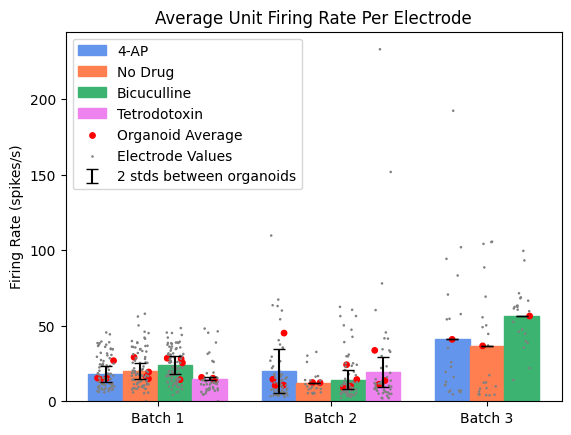

In [8]:
# FIRING RATE BAR PLOT


# Get Data
global_query = ephys.CuratedClustering.Unit()
Values = ["spike_count" , "electrode"]

data = plot.data.get_data(Tasks=Tasks , global_query=global_query , Values=Values)


# Convert Data (spike_count --> average firing rate per electrode)
new_data = {}
for key , value in data.items():

    if value == "no data":
        new_data[key] = "no data"    

    else:

        electrodes = value["electrode"]
        spike_count = value["spike_count"]

        # extract organoid number and get electrodes in organoid
        organoid = key.split("/")[2]
        used_elec = El2ROW[list(range(used_electrodes[organoid]))]

        # find number of seconds in task
        times = key.split("/")[-2:]
        N = (datetime.datetime.strptime(times[1] , "%Y-%m-%d %H:%M:%S") - datetime.datetime.strptime(times[0] , "%Y-%m-%d %H:%M:%S")).total_seconds()

        elec_fr_list = []
        for elec in used_elec:
            if elec in electrodes:
                
                elec_spike_count = spike_count[electrodes == elec]
                elec_fr = np.mean(elec_spike_count) / N # spikes/s (on average per unit for a electrode)

                elec_fr_list.append(elec_fr)

            else:
                elec_fr_list.append(0)

        new_data[key] = elec_fr_list


# Group Data
firing_rate = plot.data.group_data(data=new_data , batch=True , drug=True , organoid=True)

# reorder (based on drug chronicalogically)
order = ["4-AP" , "No Drug" , "Bicuculline" , "Tetrodotoxin"]
firing_rate = plot.reorder_dict(dict1=firing_rate , order=order)


# Format Data
drug_fr = plot.format.unest_layer(dict1=firing_rate)
drug_fr_avg = plot.format.unest_layer(dict1=firing_rate , take_average=True)

bar_data , error_data , org_data = plot.format.bar(data=drug_fr_avg)
_ , _ , elec_data = plot.format.bar(data=drug_fr)

labels = plot.format.get_labels(dict1=drug_fr)


# Plot Data
datadict = {"bar_drug":{"xvalues":bar_data["xvalues"] , "bar_data":bar_data["data"]},
            "errorbar_drug":{"xvalues":error_data["xvalues"] , "yvalues":bar_data["data"] , "errorbar_data":error_data["data"]},
             "scatter_org":{"xvalues":org_data["xvalues"] , "scatter_data":org_data["data"]},
              "scatter_elec":{"xvalues":elec_data["xvalues"] , "scatter_data":elec_data["data"]}
              }

figure_data = np.empty((1,1) , dtype=object)
figure_key = np.empty((1,1) , dtype=object)

figure_data[0,0] = datadict
figure_key[0,0] = "/".join(list(datadict.keys()))

fig , ax , plot_ax = plot.plot.get_figure(figure_key=figure_key , figure_data=figure_data)


# Customize Plot
plot_axes = plot_ax[0,0]

bar_colors = {
    "4-AP":"cornflowerblue",
    "No Drug":"coral",
    "Bicuculline":"mediumseagreen",
    "Tetrodotoxin":"violet"
}
bidx = 0
for aidx , (axis_key , bar_labels) in enumerate(labels.items()):

    # customize bars
    for bar_key in bar_labels:
        bax = plot_axes["bar_drug"][bidx]

        bax.set_color(bar_colors[bar_key])
        
        if bidx < 4:
            bax.set_label(bar_key)

        bidx += 1

# customize errorbar
eax = plot_axes["errorbar_drug"]

eax.set_label("2 stds between organoids")

# customize organoid points
opax = plot_axes["scatter_org"]

opax.set_color('r')
opax.set_label("Organoid Average")

num_opoints = opax.get_offsets().shape[0]
opax.set_sizes([15]*num_opoints)

# customize electrode points
epax = plot_axes["scatter_elec"]

epax.set_color('grey')
epax.set_label("Electrode Values")

num_epoints = epax.get_offsets().shape[0]   
epax.set_sizes([.7]*num_epoints)

# axes
ax.set_title("Average Unit Firing Rate Per Electrode")
ax.set_xticks([.3 , 1.3 , 2.2])
ax.set_xticklabels(list(labels.keys()))
ax.set_ylabel("Firing Rate (spikes/s)")
ax.legend()


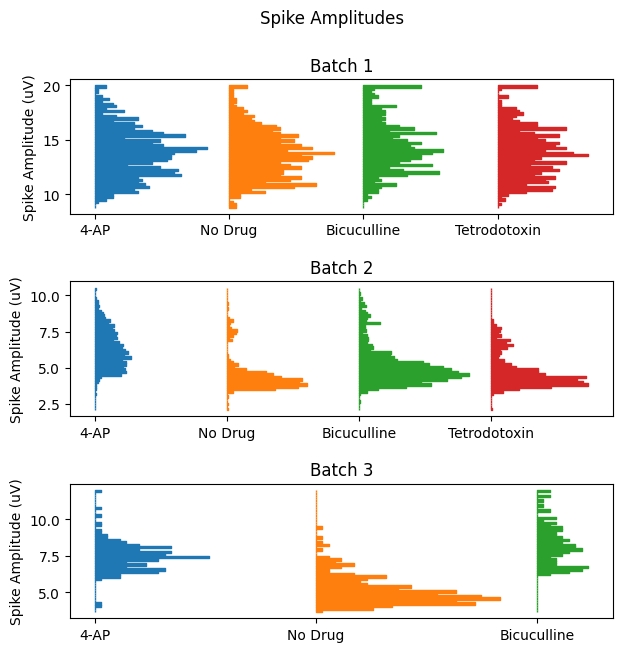

In [9]:
# SPIKE AMPLITUDE HORHIST PLOT

# Get Data (Peak Waveforms)
global_query = ephys.WaveformSet.PeakWaveform()
Values = ["peak_electrode_waveform"]

data = plot.data.get_data(Tasks=Tasks , global_query=global_query , Values=Values)


# Convert Data (Peak Waveforms --> Spike Ampltiude)
new_data = {}
no_data = []
for key , value in data.items():

    if value == "no data": # record if there's no data
        no_data.append(key)

    else: # find and record amplitude values from waveforms

        # extract waveforms from data dictionary
        Waveforms = value["peak_electrode_waveform"]

        # formatting (array([array([])])) --> array([ [], [], [] ])
        Waveforms = np.vstack(Waveforms)

        # loop through waveforms and find/record the amplitude
        amplitude = []
        for waveform in Waveforms:

            amplitude.append(abs(waveform).max())

        # Set a maximum for amplitude at 20 to avoid artifacts
        amplitude = list(np.clip(a=np.array(amplitude) , a_min=None , a_max=20))    

        # Put back into data dictionary with the same key (same key is important)
        new_data[key] = amplitude


# Group Data
# For Amplitude Values
# Going to group by batch and drug
amp_data = plot.data.group_data(data=new_data , batch=True , drug=True)

# Reorder data
order = ["4-AP" , "No Drug" , "Bicuculline" , "Tetrodotoxin"]
amp_data = plot.reorder_dict(dict1=amp_data , order=order)


# Format Data
# Put into format to plot for horizontal histogram
# nested dictionary --> numpy arrays
horhist_data , bin_data = plot.format.horhist(data=amp_data)
labels = plot.format.get_labels(dict1=amp_data)


# Plot Data
# 3 stacked figures horizontal histograms 
# each figure has a histogram for each drug treatment
nrows = 3
ncols = 1

figure_data = np.empty((nrows,ncols) , dtype=object)
figure_key = np.empty((nrows,ncols) , dtype=object)


for idx , key in enumerate(labels):
    datadict = {}
    datadict[f"horhist_{key}"] = {"horhist_data":horhist_data[key] , "bins":bin_data[key]}

    figure_data[idx,0] = datadict
    figure_key[idx,0] = "/".join(list(datadict.keys()))

fig , ax , plot_ax = plot.plot.get_figure(figure_key=figure_key , figure_data=figure_data)


# Customize Plot
colors = {
    "4-AP":"tab:blue",
    "No Drug":"tab:orange",
    "Bicuculline":"tab:green",
    "Tetrodotoxin":"tab:red"
}


# Figure Customization
fig.suptitle(f"Spike Amplitudes")
fig.subplots_adjust(hspace=.5 , wspace=.3)
fig.set_figheight(7)
fig.set_figwidth(7)
for i , (batch , drug_list) in enumerate(labels.items()):

    # axis cutomization
    ax[i].set_title(batch)
    ax[i].set_ylabel("Spike Amplitude (uV)")
    ax[i].set_xticklabels(drug_list)

    for ii , drug in enumerate(drug_list):

        pax = plot_ax[i][0][f"horhist_{batch}"][ii] # plot_ax[x][y][plot_type_dict][drug_idx]

        for hor_bar in pax:
            hor_bar.set_color(colors[drug])

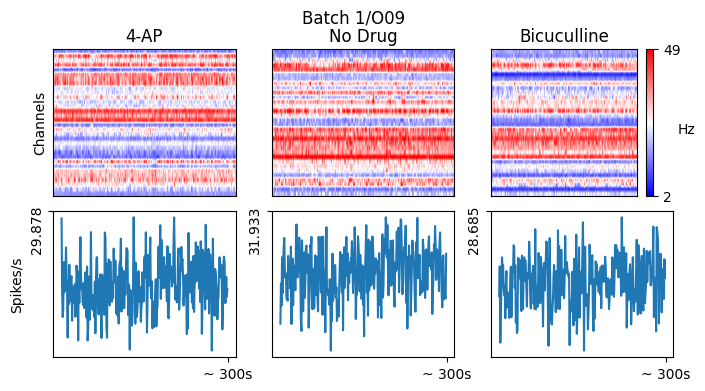

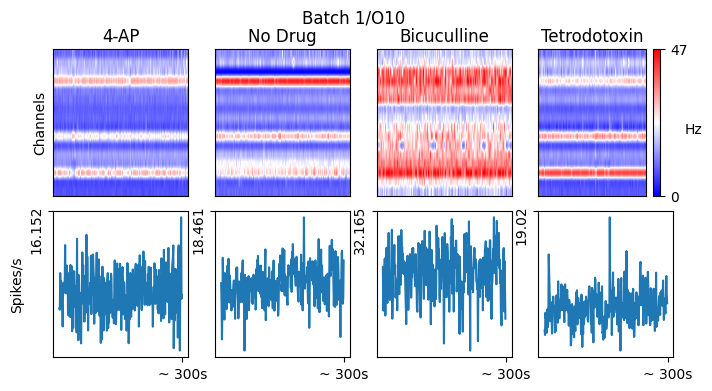

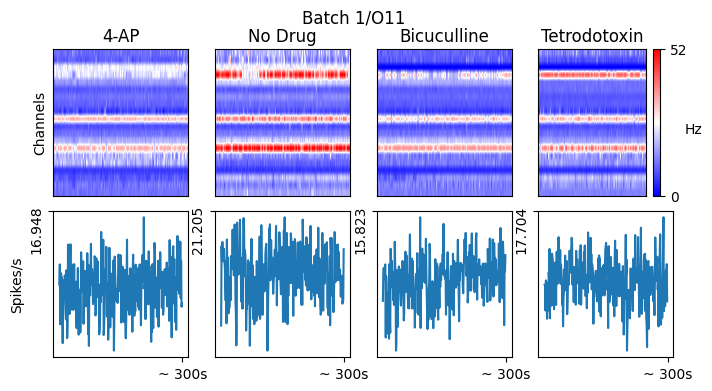

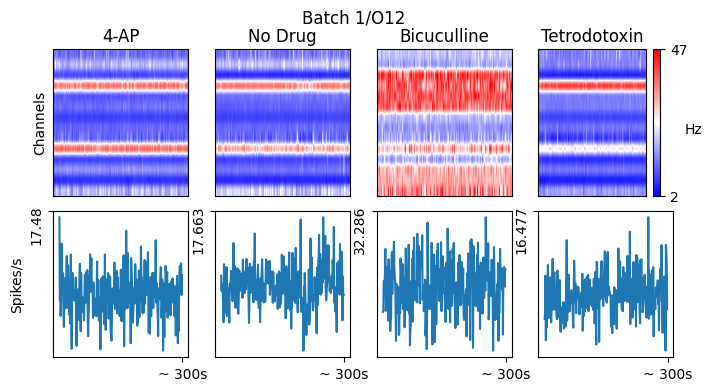

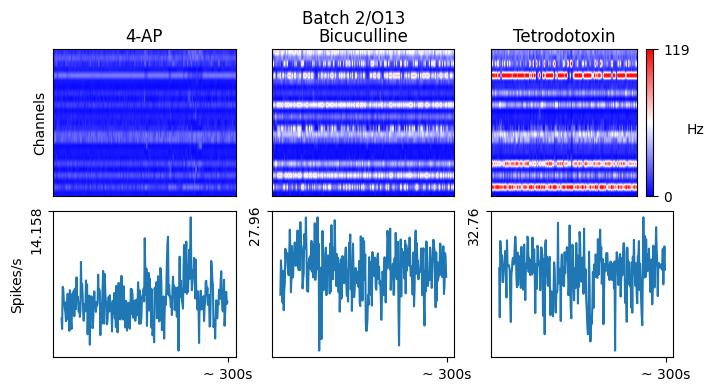

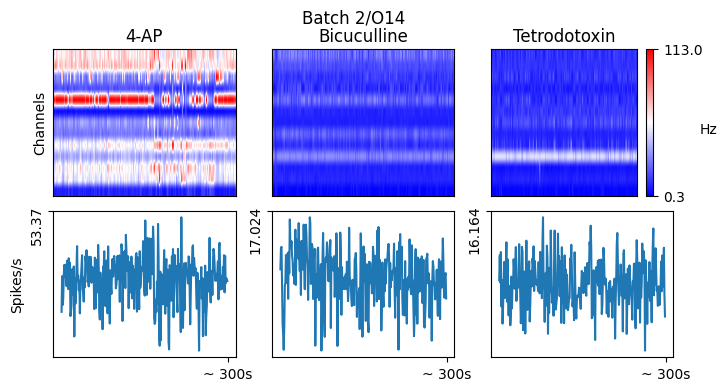

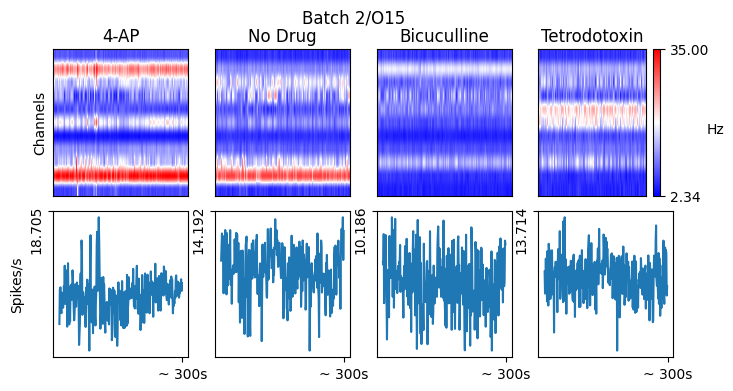

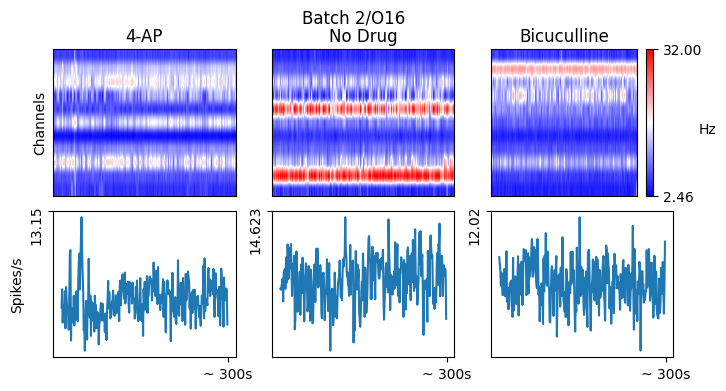

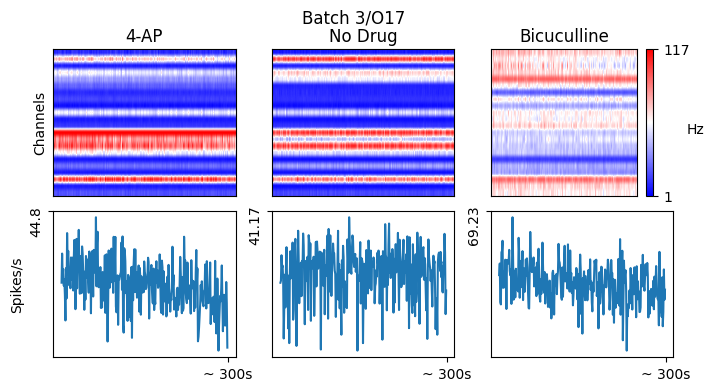

In [10]:
# FIRING MAP IMAGE PLOT
# Tasks need to be the same length in time

# Get Data (Spike times and electrodes)
global_query = ephys.CuratedClustering.Unit() 
Values = ["electrode" , "spike_times"]

data = plot.data.get_data(Tasks=Tasks , global_query=global_query , Values=Values)


# Convert Data
new_data = {}
time_vec = list(range(0 , 301))

for key , value in data.items():
    
    if value == "no data":
        new_data[key] = "no data"

    else:

        # extract Values
        electrodes = value["electrode"]
        spike_times = value["spike_times"]

        # extract organoid number
        organoid = key.split("/")[2]

        # loop through valid electrodes (inside organoid)
        # group together the same electrodes and convert to histogram

        used_elec = El2ROW[list(range(used_electrodes[organoid]))]
        spike_array = np.empty((0,300) , dtype=int)
        elec_list = []

        for elec in used_elec:
            if elec in electrodes:

                # find spikes for single electrode
                elec_spikes = np.concatenate(spike_times[electrodes == elec])
            
                # convert into histogram format
                elec_spike_hist , _ = np.histogram(elec_spikes , bins = time_vec)

                # average firing rate based on number of units per electrode
                elec_spike_hist = elec_spike_hist/len(spike_times[electrodes == elec])
                
                # append to global
                spike_array = np.append(spike_array , [list(elec_spike_hist)] , axis=0)
                elec_list.append(elec)   
            else:
                spike_array = np.append(spike_array , [list(np.zeros(300))] , axis=0)

        # limit data to 95th percentile
        p95 = int(np.percentile(spike_array , 95))
        spike_array[spike_array > p95] = p95

        new_data[key] = spike_array


# Group Data
spike_data = plot.data.group_data(data=new_data , batch=True , drug=True , organoid=True , dict_order=["batch/organoid" , "drug"])

# reorder (based on drug chronicalogically)
order = ["4-AP" , "No Drug" , "Bicuculline" , "Tetrodotoxin"]
spike_data = plot.reorder_dict(dict1=spike_data , order=order)


# Format Data
labels = plot.format.get_labels(spike_data)
cbar_lims = plot.format.image(data=spike_data , cbar_lims=[0,100])


# Plot Data

# initialize
fig = []
axes = []
plot_axes = []

# makes a new figure for each dictionary iteration
for fig_key , plot_keys in labels.items():

    nrows = 2
    ncols = len(plot_keys)

    # initialize fig variabless
    figure_data = np.empty((nrows,ncols) , dtype=object)
    figure_key = np.empty((nrows,ncols) , dtype=object)

    # set figure key
    figure_key[0,:] = "image"
    figure_key[1,:] = "line"

    # set figure data and key
    for idx , pkey in enumerate(plot_keys):
        plot_data = spike_data[fig_key][pkey]

        datadict = {}
        datadict[f"image_{pkey}"] = {"image_data" : plot_data}
        datadict[f"line_{pkey}"] = {"line_data" : np.mean(plot_data , axis=0)}

        figure_data[:,idx] = datadict
        figure_key[0,idx] = f"image_{pkey}"
        figure_key[1,idx] = f"line_{pkey}"

    # plot data
    f , ax , pax = plot.plot.get_figure(figure_key=figure_key , figure_data=figure_data) 
    fig.append(f)
    axes.append(ax)
    plot_axes.append(pax)


# Customize Plot

for fidx , (fig_key , plot_keys) in enumerate(labels.items()):

    for aidx , pkey in enumerate(plot_keys):

        # axis Customization (image = 0 , line = 1)
        # image
        iax = axes[fidx][0,aidx] 

        iax.set_aspect("auto")
        iax.set_title(pkey)
        iax.set_xticks([])
        iax.set_yticks([])
        if aidx == 0:
            iax.set_ylabel("Channels")

        # plot axis Customization
        pax = plot_axes[fidx][0,aidx][f"image_{pkey}"]

        norm = mcolors.Normalize(vmin=cbar_lims[fig_key][0] , vmax=cbar_lims[fig_key][1])
        pax.set_cmap("bwr")
        pax.set_norm(norm=norm)

        # line
        lax = axes[fidx][1,aidx]
        N = len(plot_axes[fidx][1,aidx][f"line_{pkey}"][0].get_xdata())

        lax.set_xticks([N])
        lax.set_xticklabels([f"~ {N}s"])
        lax.set_yticks([lax.get_ylim()[1]])
        lax.tick_params(axis='y', labelrotation=90)
        if aidx == 0:
            lax.set_ylabel("Spikes/s")
        
    # figure customization
    f = fig[fidx]

    f.suptitle(fig_key)
    f.set_figheight(4)
    f.set_figwidth(8)
    f.subplots_adjust(hspace=.1 , wspace=.2)
    
    cbar = f.colorbar(pax , ax=iax , ticks = cbar_lims[fig_key])
    cbar.set_label("Hz" , loc="center" , rotation=0)

No data for Batch 1/No Drug/O11/2023-05-18 18:44:00/2023-05-18 18:49:00


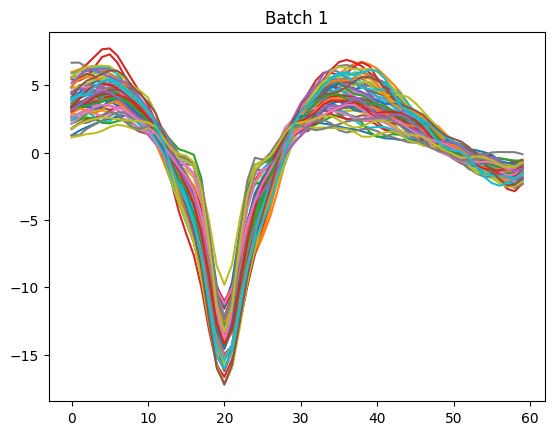

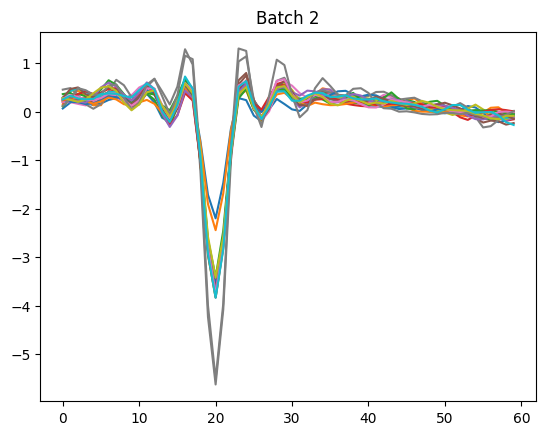

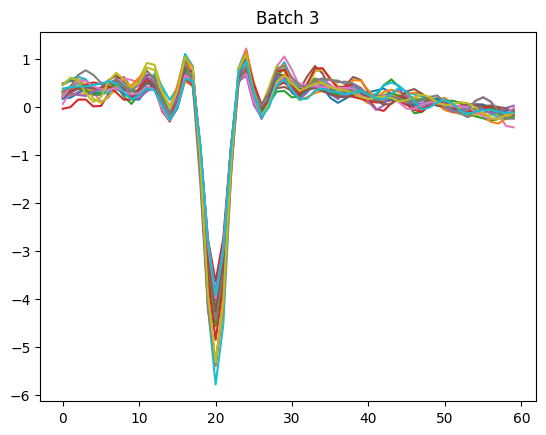

In [4]:
# WAVEFORM INVESTIGATION


# Get Data (Peak Waveforms)
global_query = ephys.WaveformSet.PeakWaveform()
Values = ["peak_electrode_waveform"]

data = plot.data.get_data(Tasks=Tasks , global_query=global_query , Values=Values)


# Convert Data
new_data = {}
no_data = []
for key , value in data.items():

    if value == "no data": # record if there's no data
        no_data.append(key)

    else: # find and record amplitude values from waveforms

        # extract waveforms from data dictionary
        Waveforms = value["peak_electrode_waveform"]

        # formatting (array([array([])])) --> array([ [], [], [] ])
        Waveforms = np.vstack(Waveforms)    

        # put back into data dictionary with the same key (same key is important)
        new_data[key] = Waveforms


# Group Data
we_data = plot.data.group_data(data=new_data , batch=True)


# Plot Data
for batch , waveforms in we_data.items():
    
    plt.figure()
    plt.title(batch)

    for waveform in waveforms:

        if np.max(abs(waveform)) < 20:
            plt.plot(waveform)

4
2
1


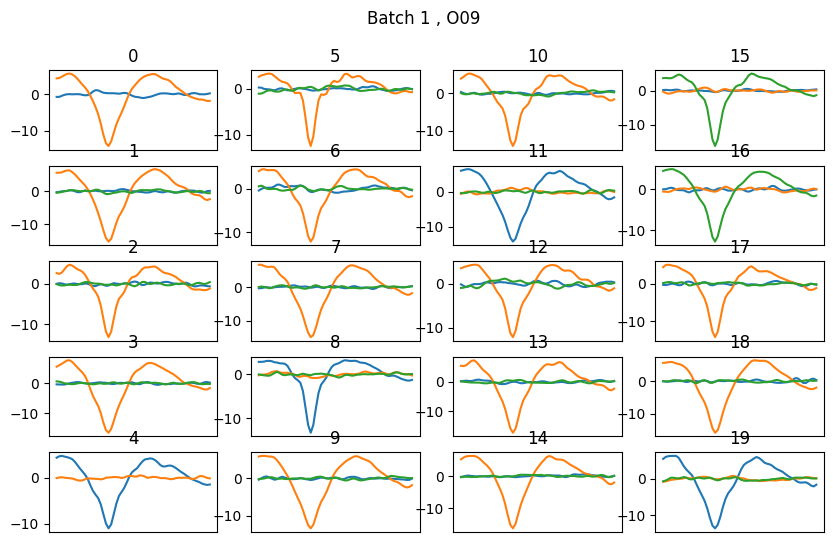

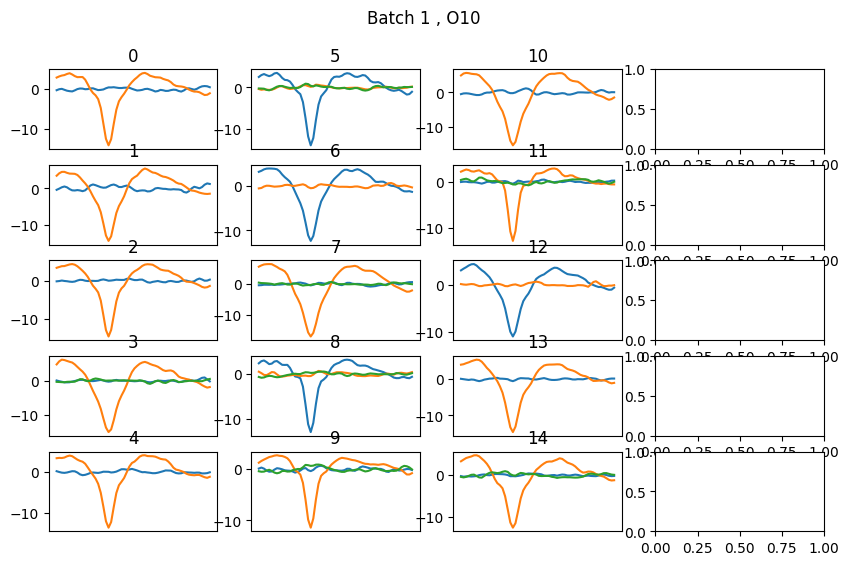

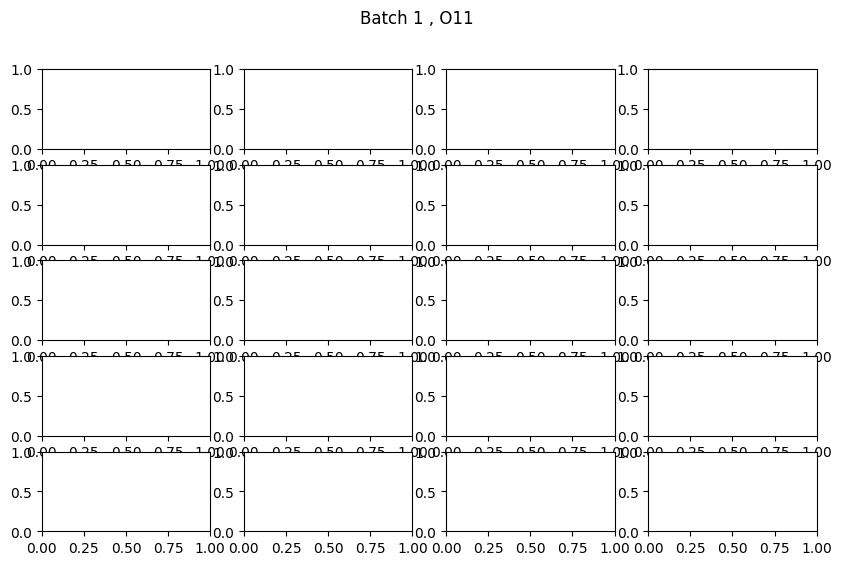

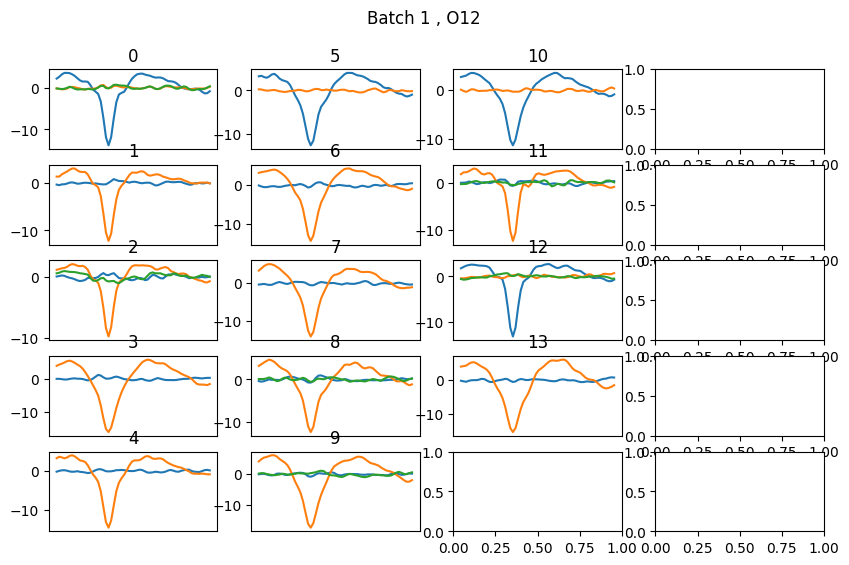

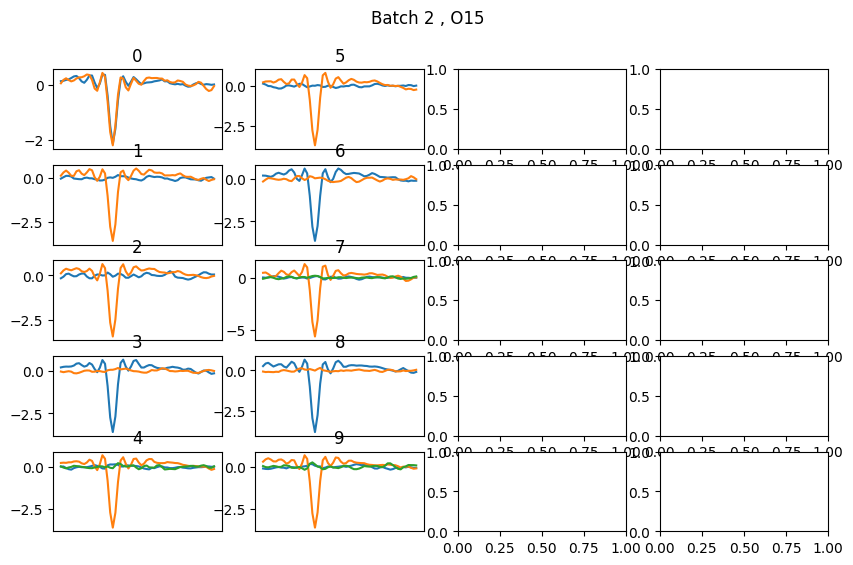

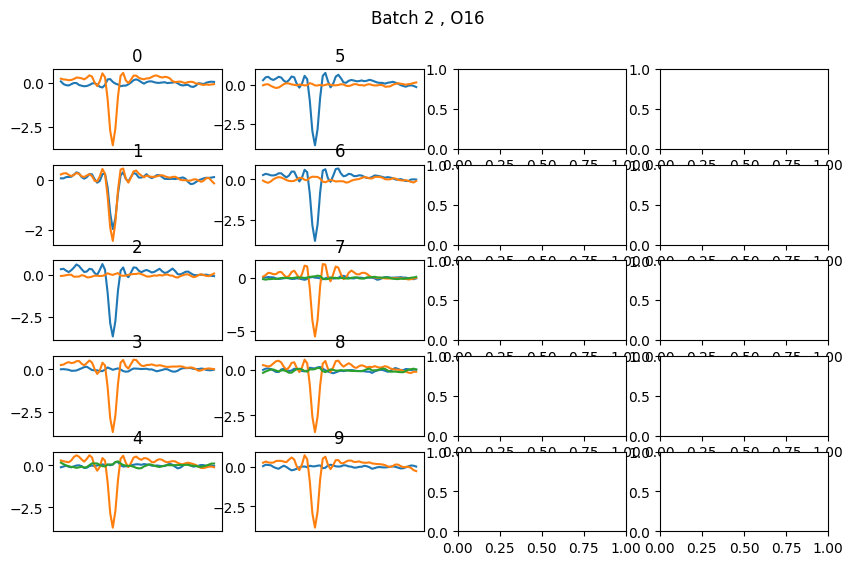

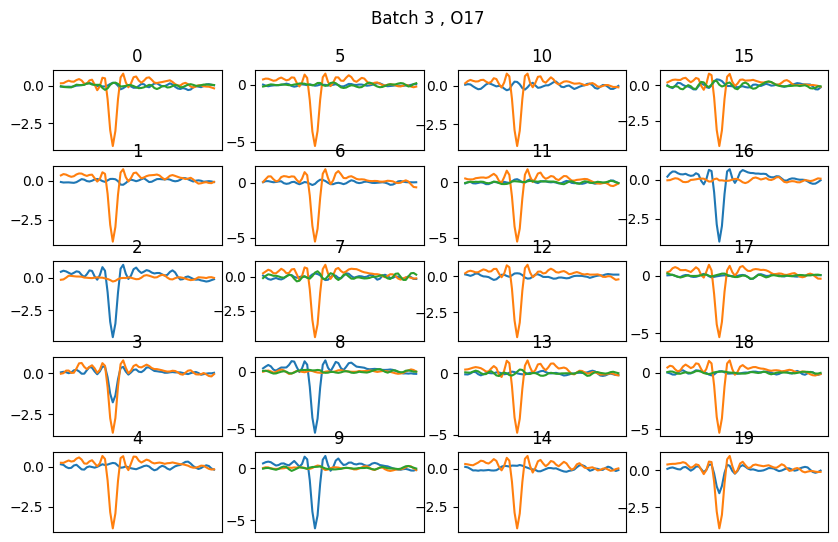

In [5]:
# Find mean waveforms
batch_folders = {"Batch 1":"O09-12" , "Batch 2":"O13-16" , "Batch 3":"O17-20"}

for batch in Batches:
    # filtered_tasks = Tasks & f"organoid_id IN {tuple(Organoids[batch])}" & f"clustering_output_dir LIKE '{batch_folders[batch]}%'"
    filtered_tasks = Tasks & f"organoid_id IN {tuple(Organoids[batch])}" & f"clustering_output_dir LIKE '{batch_folders[batch]}%'"
    key = filtered_tasks.fetch("KEY")
    print(len(key))

    for k in key:

        fig , ax = plt.subplots(nrows=5 , ncols=4, figsize =(10,6))
        fig.suptitle(f"{batch} , {k['organoid_id']}")
        x = 0
        y = 0

        query = ephys.WaveformSet.Waveform & k
        units = np.unique(query.fetch("unit"))


        for i in range(min(len(units),20)):

            if (i%5 == 0) & (i!=0):
                x = 0
                y += 1    

            unit_query = query & f"unit = '{units[i]}'"
            we_raw = np.transpose(np.vstack(unit_query.fetch("waveform_mean")))

            # filtering
            we = we_raw[: , np.sum(we_raw,axis=0) != 0] # remove channels with 0 voltage
            # we = we[: , np.max(abs(we),axis=0) < 3] # remove channels with a max over a certain threshold

            if we.shape[1] > 3:
                most_active_channels = np.max(abs(we),axis=0)
                we = we[: , np.argpartition(most_active_channels , -3)[-3:]] # get 3 most active channels

            ax[x,y].plot(we)
            ax[x,y].set_title(f'{i}')
            ax[x,y].set_xticks([])

            x += 1


In [14]:
data_we["Batch 1/No Drug/O09/2023-05-18 18:44:00/2023-05-18 18:49:00"]["peak_electrode_waveform"]

array([array([  4.34771967,   4.42922878,   4.79387903,   5.21858883,
                5.55554962,   5.66124249,   5.4131999 ,   4.93389273,
                4.24047232,   3.41445136,   2.57594895,   1.79322064,
                0.86228997,  -0.45396   ,  -1.89384067,  -3.51818943,
               -5.43737841,  -8.01254654, -11.03231812, -13.40781498,
              -14.12853527, -12.89144611, -10.5378027 ,  -8.24420834,
               -6.55043983,  -5.04815817,  -3.35516953,  -1.49097013,
                0.19305004,   1.47224963,   2.32283974,   3.16796947,
                3.94250941,   4.5068388 ,   4.92531109,   5.21586084,
                5.39058161,   5.54033756,   5.49276018,   5.10704899,
                4.66556931,   4.27439976,   4.10124016,   3.89531898,
                3.40898943,   2.67383814,   1.96286964,   1.48394978,
                0.94769979,   0.42900014,  -0.07019995,  -0.45824999,
               -0.79247987,  -1.04441965,  -1.25813985,  -1.44105017,
               -1.42

No data for Batch 1/No Drug/O11/2023-05-18 18:44:00/2023-05-18 18:49:00
No data for Batch 1/No Drug/O11/2023-05-18 18:44:00/2023-05-18 18:49:00


/var/folders/kj/qkc_fs3j2rx6nfm3mpsqdf940000gn/T/ipykernel_16944/3447296661.py:64: RuntimeWarning: invalid value encountered in divide
  new_data_window[key] = (unit_window_array / unit_window_total[:,np.newaxis]) * 100


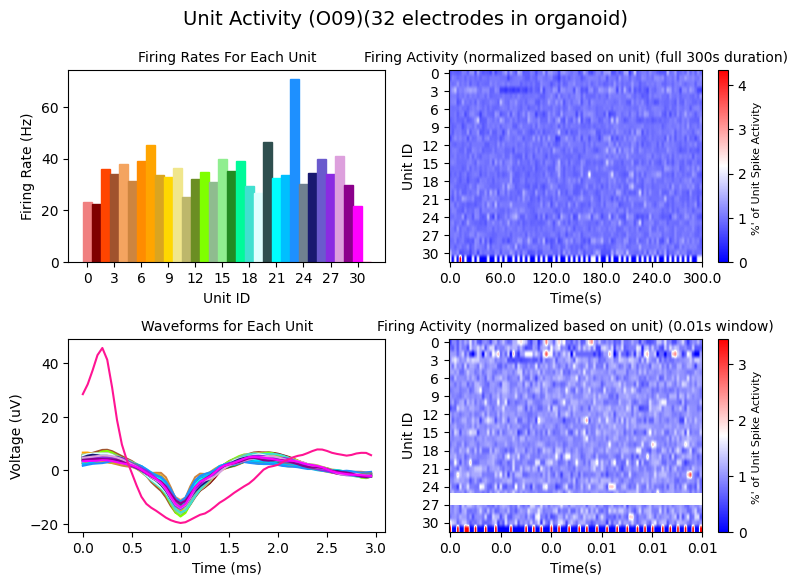

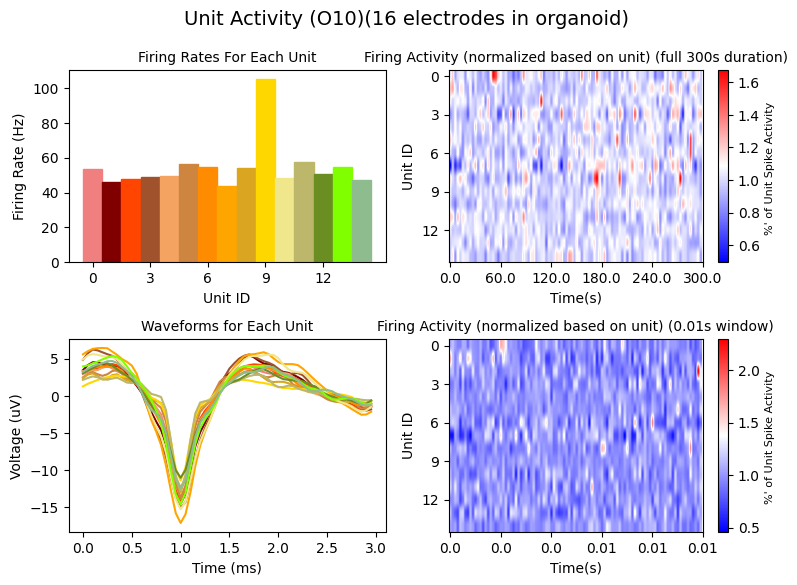

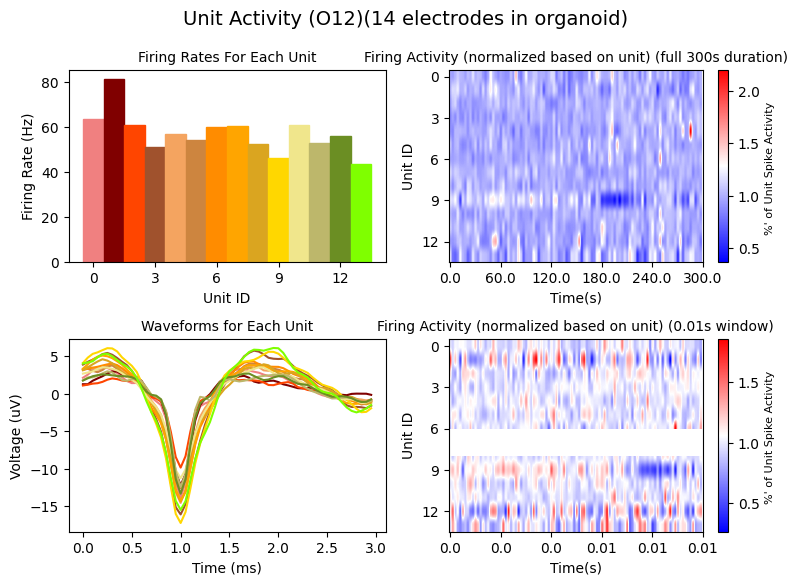

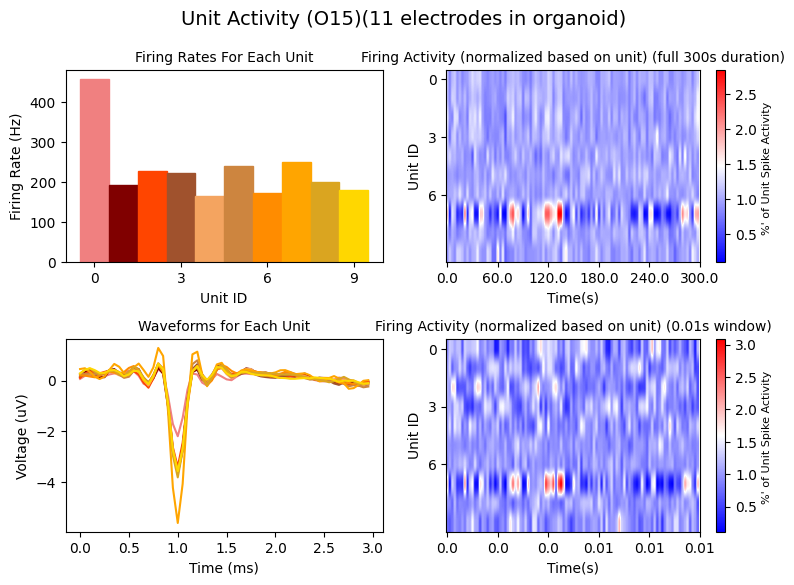

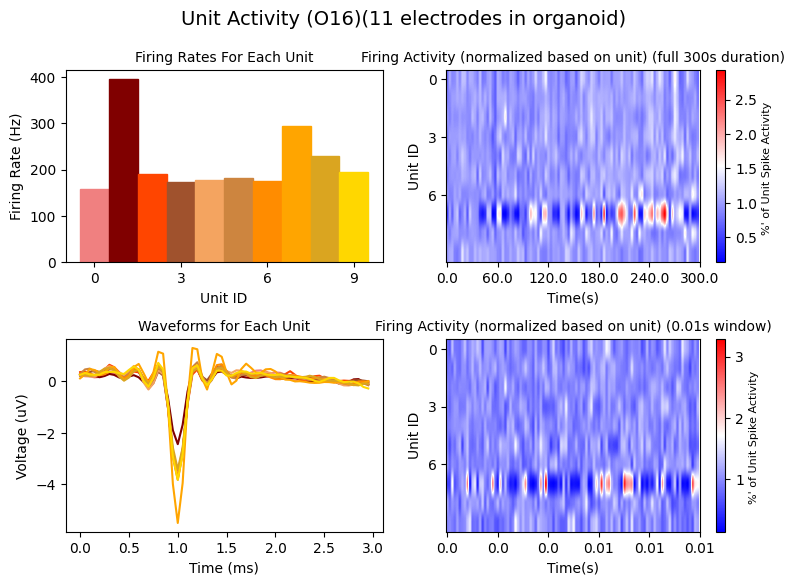

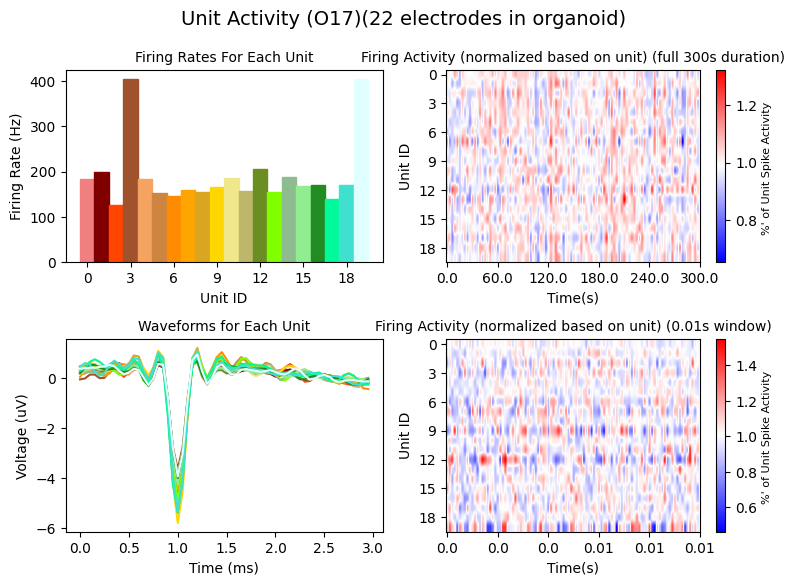

In [4]:
# Unit investigation (Per organoid)
N = 100 # number of time tiles
window_size = .01 # time window (number of seconds) (None = all time period)
# if windowsize is int or float -> it will be a random window of that size
# if it's a list it'll be a window betwween those 2 points

# Get data 
global_query = ephys.CuratedClustering.Unit()
Values = ["spike_times" , "start_time" , "end_time"]

data = plot.data.get_data(Tasks=Tasks , global_query=global_query , Values=Values)
data_we = plot.data.get_data(Tasks=Tasks , global_query=ephys.WaveformSet.PeakWaveform() , Values=["peak_electrode_waveform"])

# Convert data
new_data = {}
new_data_window = {}
firing_rate = {}
waveforms = {}

for key , value in data.items():

    if not value == "no data":
        
        spike_times = value["spike_times"]

        start_time = value["start_time"][0]
        end_time = value["end_time"][0]
        T = int((end_time-start_time).total_seconds()) # total time

        we = data_we[key]["peak_electrode_waveform"]

        unit_list = []
        unit_window_list = []
        for unit_spikes in spike_times:
            
            # window
            if isinstance(window_size , int) or isinstance(window_size , float):
                rand_start = np.random.randint(0 , np.max(unit_spikes)-window_size)
                unit_spikes_window = unit_spikes[unit_spikes > rand_start]
                unit_spikes_window = unit_spikes[unit_spikes < rand_start+window_size]
            elif isinstance(window_size , list):
                unit_spikes_window = unit_spikes[unit_spikes > window_size[0]]
                unit_spikes_window = unit_spikes[unit_spikes < window_size[1]]

            # histogram
            unit_spike_hist , _ = np.histogram(unit_spikes , bins=N)
            unit_spike_window_hist , _ = np.histogram(unit_spikes_window , bins=N)

            # append to list
            unit_list.append(unit_spike_hist)
            unit_window_list.append(unit_spike_window_hist)
        
        # list-->array
        unit_array = np.array(unit_list)
        unit_window_array = np.array(unit_window_list)

        # get sum
        unit_total = np.sum(unit_array , axis=1)
        unit_window_total = np.sum(unit_window_array , axis=1)

        
        # put in global dictionary (normalize based on unit)
        new_data[key] = (unit_array / unit_total[:,np.newaxis]) * 100
        new_data_window[key] = (unit_window_array / unit_window_total[:,np.newaxis]) * 100
        firing_rate[key] = unit_total / T
        waveforms[key] = np.vstack(we)


# Group data
spike_data = plot.data.group_data(new_data , organoid=True)
spike_data_window = plot.data.group_data(new_data_window , organoid=True)
fr_data = plot.data.group_data(firing_rate , organoid=True)
we_data = plot.data.group_data(waveforms , organoid=True)

labels = plot.format.get_labels(spike_data)
fr_data = plot.format.bar(fr_data , groups=False)

# plot data
nrows = 2
ncols = 2
fig = []
axes = []
plot_axes = []
t_we = np.arange(len(we_data["O09"][0])) / (20000/1000)

for key in labels:
    figure_data = np.empty((nrows,ncols) , dtype=object)
    figure_key = np.empty((nrows,ncols) , dtype=object)

    figure_key[0,0] = "bar_fr"
    figure_key[1,0] = "line_we"
    figure_key[0,1] = "image_total"
    figure_key[1,1] = "image_window"

    figure_data[0,0] = {"bar_fr":{"bar_data":fr_data["data"][key] , "xvalues":fr_data["xvalues"][key]}}
    figure_data[1,0] = {"line_we":{"line_data":np.transpose(we_data[key]) , "xvalues":t_we}}
    figure_data[0,1] = {"image_total":{"image_data":spike_data[key]}}
    figure_data[1,1] = {"image_window":{"image_data":spike_data_window[key]}}

    # plot data
    f , ax , pax = plot.plot.get_figure(figure_key=figure_key , figure_data=figure_data) 
    fig.append(f)
    axes.append(ax)
    plot_axes.append(pax)
    
# customize plot
color_list = ["lightcoral","maroon","orangered","sienna","sandybrown","peru","darkorange","orange",
                "goldenrod","gold","khaki","darkkhaki","olivedrab","chartreuse","darkseagreen","lightgreen",
                "forestgreen","mediumspringgreen","turquoise","lightcyan","darkslategrey","aqua","deepskyblue","dodgerblue",
                "slategrey","midnightblue","slateblue","blueviolet","plum","darkmagenta","magenta","deeppink"]

for fidx , key in enumerate(labels):

    num_units = len(plot_axes[fidx][0,0]["bar_fr"])
    
    # Figure
    f = fig[fidx]
    f.suptitle(f"Unit Activity ({key})({used_electrodes[key]} electrodes in organoid)" , fontsize=14)
    f.set_figheight(6)
    f.set_figwidth(9)
    f.subplots_adjust(hspace=.4 , wspace=.2)

    # Axes
    # bar
    bar_ax = axes[fidx][0,0]
    bar_ax.set_title("Firing Rates For Each Unit" , fontsize=10)
    bar_ax.set_ylabel("Firing Rate (Hz)")
    bar_ax.set_xlabel("Unit ID")
    bar_ax.set_xticks(np.arange(0,num_units,3)*.2 , range(0,num_units,3))
    # line
    line_ax = axes[fidx][1,0]
    line_ax.set_title("Waveforms for Each Unit" , fontsize=10)
    line_ax.set_ylabel("Voltage (uV)")
    line_ax.set_xlabel("Time (ms)")
    # image total
    img1_ax = axes[fidx][0,1]
    img1_ax.set_title(f"Firing Activity (normalized based on unit) (full {T}s duration)" , fontsize=10)
    img1_ax.set_ylabel("Unit ID")
    img1_ax.set_xlabel("Time(s)")
    img1_ax.set_aspect("auto")    
    img1_ax.set_yticks(np.arange(0 , num_units-1 , 3))
    img1_ax.set_xticks(np.linspace(0,N,6) , np.round(np.linspace(0,T,6),1))
    # image window
    img2_ax = axes[fidx][1,1]
    img2_ax.set_title(f"Firing Activity (normalized based on unit) ({window_size}s window)" , fontsize=10)
    img2_ax.set_ylabel("Unit ID")
    img2_ax.set_xlabel("Time(s)")
    img2_ax.set_aspect("auto")    
    img2_ax.set_yticks(np.arange(0 , num_units-1 , 3))
    img2_ax.set_xticks(np.linspace(0,N,6) , np.round(np.linspace(0,window_size,6),2))

    # Plot Axes
    # bar customization
    bar_pax = plot_axes[fidx][0,0]["bar_fr"]
    for i , bax in enumerate(bar_pax):
        if i <= len(color_list):
            bax.set_color(color_list[i])
        else:
            bax.set_color("grey")
    # line customization
    line_pax = plot_axes[fidx][1,0]["line_we"]
    for i , lax in enumerate(line_pax):
        if i <= len(color_list):
            lax.set_color(color_list[i])
        else:
            lax.set_color("grey")
    # image total customization
    img1_pax = plot_axes[fidx][0,1]["image_total"]
    img1_pax.set_cmap("bwr")
    cbar1 = f.colorbar(img1_pax , ax=img1_ax)
    cbar1.set_label("%' of Unit Spike Activity " , loc="center" , rotation=90 , fontsize=8)
    # image window customization
    img2_pax = plot_axes[fidx][1,1]["image_window"]
    img2_pax.set_cmap("bwr")
    cbar2 = f.colorbar(img2_pax , ax=img2_ax)
    cbar2.set_label("%' of Unit Spike Activity " , loc="center" , rotation=90 , fontsize=8)    


In [148]:
ephys.CuratedClustering.Unit()

[2024-07-09 17:57:22,652][WARNING]: MySQL server has gone away. Reconnecting to the server.


organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,paramset_idx,unit,electrode_config_hash,probe_type e.g. A1x32-6mm-100-177-H32_21mm,"electrode electrode index, starts at 0","cluster_quality_label cluster quality type - e.g. 'good', 'MUA', 'noise', etc.",spike_count how many spikes in this recording for this unit,"spike_times (s) spike times of this unit, relative to the start of the EphysRecording",spike_sites array of electrode associated with each spike,"spike_depths (um) array of depths associated with each spike, relative to the (0, 0) of the probe"
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:30:00,0,0,699af5e0-31fa-acc9-1aeb-132c6972d25e,A1x32-6mm-100-177-H32_21mm,17,n.a.,2271,=BLOB=,=BLOB=,=BLOB=
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:30:00,0,1,699af5e0-31fa-acc9-1aeb-132c6972d25e,A1x32-6mm-100-177-H32_21mm,1,n.a.,14434,=BLOB=,=BLOB=,=BLOB=
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:30:00,0,2,699af5e0-31fa-acc9-1aeb-132c6972d25e,A1x32-6mm-100-177-H32_21mm,4,n.a.,12488,=BLOB=,=BLOB=,=BLOB=
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:30:00,0,3,699af5e0-31fa-acc9-1aeb-132c6972d25e,A1x32-6mm-100-177-H32_21mm,18,n.a.,4674,=BLOB=,=BLOB=,=BLOB=
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:30:00,0,4,699af5e0-31fa-acc9-1aeb-132c6972d25e,A1x32-6mm-100-177-H32_21mm,2,n.a.,14792,=BLOB=,=BLOB=,=BLOB=
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:30:00,0,5,699af5e0-31fa-acc9-1aeb-132c6972d25e,A1x32-6mm-100-177-H32_21mm,14,n.a.,4410,=BLOB=,=BLOB=,=BLOB=
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:30:00,0,6,699af5e0-31fa-acc9-1aeb-132c6972d25e,A1x32-6mm-100-177-H32_21mm,25,n.a.,11202,=BLOB=,=BLOB=,=BLOB=
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:30:00,0,7,699af5e0-31fa-acc9-1aeb-132c6972d25e,A1x32-6mm-100-177-H32_21mm,3,n.a.,19064,=BLOB=,=BLOB=,=BLOB=
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:30:00,0,8,699af5e0-31fa-acc9-1aeb-132c6972d25e,A1x32-6mm-100-177-H32_21mm,31,n.a.,7937,=BLOB=,=BLOB=,=BLOB=
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:30:00,0,9,699af5e0-31fa-acc9-1aeb-132c6972d25e,A1x32-6mm-100-177-H32_21mm,16,n.a.,1348,=BLOB=,=BLOB=,=BLOB=


In [123]:
list(range(0,10,3))

[0, 3, 6, 9]

In [119]:
len(plot_axes[0][0,0]["bar_fr"])

32

In [13]:
# Plot Data

# initialize
fig = []
axes = []
plot_axes = []

# makes a new figure for each dictionary iteration
for fig_key , plot_keys in labels.items():

    nrows = 2
    ncols = len(plot_keys)

    # initialize fig variabless
    figure_data = np.empty((nrows,ncols) , dtype=object)
    figure_key = np.empty((nrows,ncols) , dtype=object)

    # set figure key
    figure_key[0,:] = "image"
    figure_key[1,:] = "line"

    # set figure data and key
    for idx , pkey in enumerate(plot_keys):
        plot_data = spike_data[fig_key][pkey]

        datadict = {}
        datadict[f"image_{pkey}"] = {"image_data" : plot_data}
        datadict[f"line_{pkey}"] = {"line_data" : np.mean(plot_data , axis=0)}

        figure_data[:,idx] = datadict
        figure_key[0,idx] = f"image_{pkey}"
        figure_key[1,idx] = f"line_{pkey}"

    # plot data
    f , ax , pax = plot.plot.get_figure(figure_key=figure_key , figure_data=figure_data) 
    fig.append(f)
    axes.append(ax)
    plot_axes.append(pax)


# Customize Plot

for fidx , (fig_key , plot_keys) in enumerate(labels.items()):

    for aidx , pkey in enumerate(plot_keys):

        # axis Customization (image = 0 , line = 1)
        # image
        iax = axes[fidx][0,aidx] 

        iax.set_aspect("auto")
        iax.set_title(pkey)
        iax.set_xticks([])
        iax.set_yticks([])
        if aidx == 0:
            iax.set_ylabel("Channels")

        # plot axis Customization
        pax = plot_axes[fidx][0,aidx][f"image_{pkey}"]

        norm = mcolors.Normalize(vmin=cbar_lims[fig_key][0] , vmax=cbar_lims[fig_key][1])
        pax.set_cmap("bwr")
        pax.set_norm(norm=norm)

        # line
        lax = axes[fidx][1,aidx]
        N = len(plot_axes[fidx][1,aidx][f"line_{pkey}"][0].get_xdata())

        lax.set_xticks([N])
        lax.set_xticklabels([f"~ {N}s"])
        lax.set_yticks([lax.get_ylim()[1]])
        lax.tick_params(axis='y', labelrotation=90)
        if aidx == 0:
            lax.set_ylabel("Spikes/s")
        
    # figure customization
    f = fig[fidx]

    f.suptitle(fig_key)
    f.set_figheight(4)
    f.set_figwidth(8)
    f.subplots_adjust(hspace=.1 , wspace=.2)
    
    cbar = f.colorbar(pax , ax=iax , ticks = cbar_lims[fig_key])
    cbar.set_label("Hz" , loc="center" , rotation=0)

['O09', 'O10', 'O11', 'O12', 'O15', 'O16', 'O17']

In [ ]:
# group data
spike_data = plot.data.group_data(new_data , organoid=True)
spike_data_window = plot.data.group_data(new_data_window , organoid=True)

labels = plot.format.get_labels(spike_data)

# plot data
nrows = 2
ncols = 1

figure_data = np.empty((nrows,ncols) , dtype=object)
figure_key = np.empty((nrows,ncols) , dtype=object)

for key in labels:

    figure_data[0,0] = {"image_total":{"image_data":spike_data[key]}}
    figure_data[1,0] = {"image_window":{"image_data":spike_data_window[key]}}

    figure_key[0,0] = "image_total"
    figure_key[1,0] = "image_window"

fig , ax , plot_ax = plot.plot.get_figure(figure_key=figure_key , figure_data=figure_data)

for idx, p in enumerate(plot_ax):
    p = p[0]

    pax = list(p.values())[0]
    pax.set_cmap("bwr")
    cbar = fig.colorbar(pax , ax=ax[idx])
    cbar.set_label("Hz" , loc="center" , rotation=0)

for a in ax:
    a.set_aspect("auto")
    a.set_yticks([0 , unit_array.shape[0]-1])
    a.set_ylabel("Units")
    a.set_xlabel("Time (s)")

ax[0].set_title("Full task time")
ax[0].set_xticks(np.arange(6)*int((N/5)))
ax[0].set_xticklabels(np.arange(6) * 60)


ax[1].set_title(f"Window ({window_size}s)")
ax[1].set_xticks(np.arange(6)*int((N/5)))
ax[1].set_xticklabels(np.arange(6) * window_size/5)


fig.set_figheight(4)
fig.set_figwidth(8)
fig.subplots_adjust(hspace=.6)